***Objective:  Attempt to solve the P-Dispersion Problem as a script and access PuLP manually (outside of PySAL spopt ecosystem)

***Steps:
1)  Solve for P-Dispersion - The objective function of the p-dispersion problem evaluates the system in terms of the smallest distance between any pair of facilities

2)  

3)  

In [1]:
from spopt.locate.disperse import PDispersion
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
FACILITY_COUNT = 4 # quantity supply points

# Random seeds for reproducibility
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [3]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [4]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

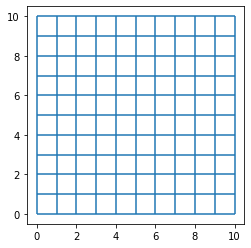

In [5]:
street.plot()

In [6]:
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

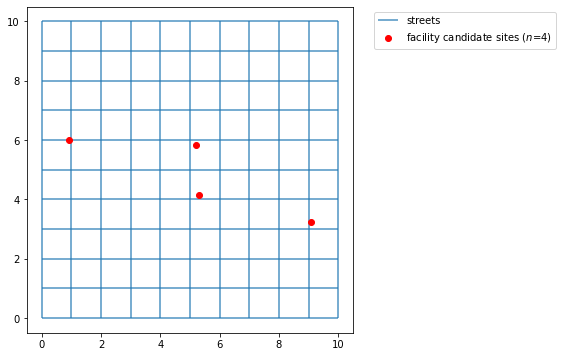

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=4)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [8]:
ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

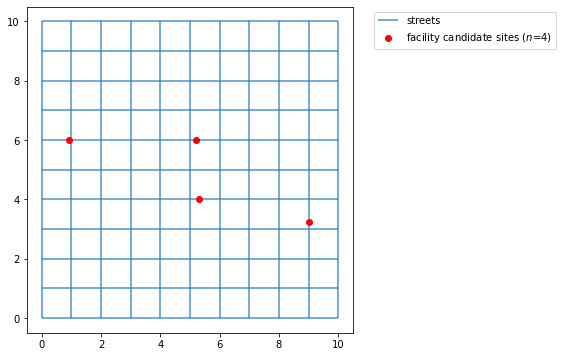

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=4)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [10]:
#create a cost matrix that tracks facility - to - facility distances
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["facilities"],
    destpattern=ntw.pointpatterns["facilities"]
)
cost_matrix

array([[ 0.        , 10.82778055,  4.43730946,  6.55983134],
       [10.82778055,  0.        ,  6.3904711 ,  4.26794921],
       [ 4.43730946,  6.3904711 ,  0.        ,  2.49767925],
       [ 6.55983134,  4.26794921,  2.49767925,  0.        ]])

All code before this is pre-problem setup. Now with the information we have we must create a PuLP problem and use the PuLP solver to solve for P-Dispersion.

Below I attempt to solve for P-Dispersion using the spopt package edits I've made.

In [11]:
#number of facilities to be sited
p = 2

disperse_from_cost_matrix = PDispersion.from_cost_matrix(cost_matrix, p)
disperse_from_cost_matrix = disperse_from_cost_matrix.solve(solver)

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/pulp/pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [12]:
disperse_from_cost_matrix

In [13]:
disperse_from_cost_matrix.problem

P-Dispersion:
MAXIMIZE
-1*D + -10.827780553533692*y_2_ + -10.827780553533692*y_3_ + 24.153240358665123
SUBJECT TO
_C1: y_0_ + y_1_ + y_2_ + y_3_ = 2

VARIABLES
D Continuous
0 <= y_0_ <= 1 Integer
0 <= y_1_ <= 1 Integer
0 <= y_2_ <= 1 Integer
0 <= y_3_ <= 1 Integer

In [14]:
disperse_from_cost_matrix.problem.status

1

In [15]:
print('\n'+ 'Chosen Facility Values')
for i in disperse_from_cost_matrix.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values
y_0_ 1.0
y_1_ 1.0


In [23]:
print(disperse_from_cost_matrix.disperse_var, disperse_from_cost_matrix.disperse_var.varValue)

D 0.0


Solve for p-dispersion using a geodataframe with no predefined facilities

In [16]:
facilities_snapped['predefined_loc'] = numpy.array([0, 0, 0, 1])
facilities_snapped

,id,geometry,comp_label,predefined_loc
0,0,POINT (9.00000 3.25259),0,0
1,1,POINT (0.91963 6.00000),0,0
2,2,POINT (5.31010 4.00000),0,0
3,3,POINT (5.18758 6.00000),0,1


In [17]:
#number of facilities to be sited
p = 2

disperse_from_geodataframe = PDispersion.from_geodataframe(facilities_snapped, "geometry", p, distance_metric="euclidean")
disperse_from_geodataframe = disperse_from_geodataframe.solve(solver)

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/pulp/pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [18]:
print('\n'+ 'Chosen Facility Values')
for i in disperse_from_geodataframe.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values
y_0_ 1.0
y_1_ 1.0


Now solve for p-dispersion using a geodataframe and include a predefined facility

In [19]:
#number of facilities to be sited
p = 2

disperse_from_geodataframe = PDispersion.from_geodataframe(facilities_snapped, "geometry", p, predefined_facility_col="predefined_loc", distance_metric="euclidean")
disperse_from_geodataframe = disperse_from_geodataframe.solve(solver)

In [20]:
print('\n'+ 'Chosen Facility Values')
for i in disperse_from_geodataframe.fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)


Chosen Facility Values
y_0_ 1.0
y_3_ 1.0
